# Linear Regression from Scratch

This notebook implements linear regression from first principles, connecting every line of code to the mathematics.

## Objectives
1. Implement OLS using the normal equations
2. Implement OLS using gradient descent
3. Add L2 regularization (Ridge)
4. Visualize the bias-variance tradeoff with polynomial regression

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

np.random.seed(42)
plt.style.use('seaborn-v0_8-whitegrid')

## 1. Generate Synthetic Data

I'll create data from a known linear model plus noise:
$$y = w^*{}^\top x + \varepsilon, \quad \varepsilon \sim \mathcal{N}(0, \sigma^2)$$

In [11]:
def generate_linear_data(n_samples=100, n_features=2, noise_std=0.5, w_true=None):
    """Generate data from linear model y = Xw + noise."""
    X = np.random.randn(n_samples, n_features)
    
    if w_true is None:
        w_true = np.random.randn(n_features)
    
    y = X @ w_true + noise_std * np.random.randn(n_samples)
    
    return X, y, w_true

# Generate data
X, y, w_true = generate_linear_data(n_samples=200, n_features=3, noise_std=0.5)
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"True weights: {w_true}")

X shape: (200, 3)
y shape: (200,)
True weights: [ 0.75698862 -0.92216532  0.86960592]


## 2. Normal Equations Solution

The closed-form solution:
$$w^* = (X^\top X)^{-1} X^\top y$$

I'll implement this, but use `np.linalg.solve` instead of explicitly computing the inverse.

In [12]:
class LinearRegressionNormalEq:
    """Linear regression using normal equations."""
    
    def __init__(self, fit_intercept=True):
        self.fit_intercept = fit_intercept
        self.w = None
        self.b = 0
    
    def fit(self, X, y):
        """Fit using normal equations: w* = (X^T X)^{-1} X^T y"""
        n, d = X.shape
        
        if self.fit_intercept:
            # Add bias column
            X_aug = np.column_stack([np.ones(n), X])
        else:
            X_aug = X
        
        # Normal equations: (X^T X) w = X^T y
        # Using solve instead of inverse for numerical stability
        XtX = X_aug.T @ X_aug
        Xty = X_aug.T @ y
        w_full = np.linalg.solve(XtX, Xty)
        
        if self.fit_intercept:
            self.b = w_full[0]
            self.w = w_full[1:]
        else:
            self.w = w_full
        
        return self
    
    def predict(self, X):
        return X @ self.w + self.b
    
    def score(self, X, y):
        """R^2 score."""
        y_pred = self.predict(X)
        ss_res = np.sum((y - y_pred)**2)
        ss_tot = np.sum((y - y.mean())**2)
        return 1 - ss_res / ss_tot

# Fit and evaluate
model_ne = LinearRegressionNormalEq(fit_intercept=False)
model_ne.fit(X, y)

print(f"Estimated weights: {model_ne.w}")
print(f"True weights:      {w_true}")
print(f"R^2 score: {model_ne.score(X, y):.4f}")

Estimated weights: [ 0.80560383 -0.90603937  0.88153538]
True weights:      [ 0.75698862 -0.92216532  0.86960592]
R^2 score: 0.8922


## 3. Gradient Descent Solution

The gradient of MSE loss:
$$\nabla_w J = \frac{2}{n} X^\top (Xw - y)$$

Update rule:
$$w_{t+1} = w_t - \alpha \nabla_w J$$

In [13]:
class LinearRegressionGD:
    """Linear regression using gradient descent."""
    
    def __init__(self, learning_rate=0.01, n_iterations=1000, fit_intercept=True):
        self.lr = learning_rate
        self.n_iter = n_iterations
        self.fit_intercept = fit_intercept
        self.w = None
        self.b = 0
        self.history = []
    
    def fit(self, X, y):
        n, d = X.shape
        
        # Initialize weights
        self.w = np.zeros(d)
        self.b = 0
        self.history = []
        
        for _ in range(self.n_iter):
            # Predictions
            y_pred = X @ self.w + self.b
            
            # Compute gradients
            # J = (1/n) ||Xw - y||^2
            # dJ/dw = (2/n) X^T (Xw - y)
            residual = y_pred - y
            dw = (2/n) * (X.T @ residual)
            db = (2/n) * np.sum(residual) if self.fit_intercept else 0
            
            # Update
            self.w -= self.lr * dw
            self.b -= self.lr * db
            
            # Track loss
            loss = np.mean(residual**2)
            self.history.append(loss)
        
        return self
    
    def predict(self, X):
        return X @ self.w + self.b
    
    def score(self, X, y):
        y_pred = self.predict(X)
        ss_res = np.sum((y - y_pred)**2)
        ss_tot = np.sum((y - y.mean())**2)
        return 1 - ss_res / ss_tot

# Fit and compare
model_gd = LinearRegressionGD(learning_rate=0.1, n_iterations=500, fit_intercept=False)
model_gd.fit(X, y)

print(f"GD weights:     {model_gd.w}")
print(f"Normal Eq:      {model_ne.w}")
print(f"True weights:   {w_true}")
print(f"\nClose match: {np.allclose(model_gd.w, model_ne.w, atol=1e-3)}")

GD weights:     [ 0.80560383 -0.90603937  0.88153538]
Normal Eq:      [ 0.80560383 -0.90603937  0.88153538]
True weights:   [ 0.75698862 -0.92216532  0.86960592]

Close match: True


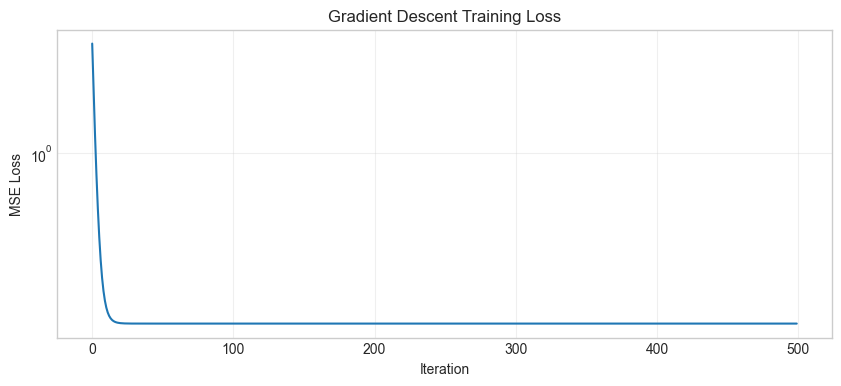

In [14]:
# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(model_gd.history)
plt.xlabel('Iteration')
plt.ylabel('MSE Loss')
plt.title('Gradient Descent Training Loss')
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.show()

## 4. Ridge Regression (L2 Regularization)

Regularized objective:
$$J_{\text{ridge}}(w) = ||y - Xw||^2 + \lambda ||w||^2$$

Closed-form solution:
$$w^* = (X^\top X + \lambda I)^{-1} X^\top y$$

In [15]:
class RidgeRegression:
    """Ridge regression with L2 regularization."""
    
    def __init__(self, alpha=1.0):
        self.alpha = alpha  # regularization strength
        self.w = None
    
    def fit(self, X, y):
        n, d = X.shape
        
        # (X^T X + λI) w = X^T y
        XtX = X.T @ X
        reg = self.alpha * np.eye(d)
        Xty = X.T @ y
        
        self.w = np.linalg.solve(XtX + reg, Xty)
        return self
    
    def predict(self, X):
        return X @ self.w

# Compare different regularization strengths
alphas = [0, 0.1, 1, 10, 100]
print(f"True weights: {w_true}\n")

for alpha in alphas:
    ridge = RidgeRegression(alpha=alpha)
    ridge.fit(X, y)
    print(f"α = {alpha:5.1f}: w = {ridge.w}, ||w|| = {np.linalg.norm(ridge.w):.3f}")

True weights: [ 0.75698862 -0.92216532  0.86960592]

α =   0.0: w = [ 0.80560383 -0.90603937  0.88153538], ||w|| = 1.499
α =   0.1: w = [ 0.80506133 -0.90561717  0.88110428], ||w|| = 1.498
α =   1.0: w = [ 0.80021089 -0.90183517  0.8772437 ], ||w|| = 1.491
α =  10.0: w = [ 0.75468644 -0.86569187  0.84045951], ||w|| = 1.423
α = 100.0: w = [ 0.47953669 -0.61829887  0.59336741], ||w|| = 0.982


**Observation:** Higher λ shrinks weights toward zero, trading bias for reduced variance.

## 5. Polynomial Regression & Bias-Variance Tradeoff

Demonstrate overfitting with polynomial features.

In [16]:
def polynomial_features(X, degree):
    """Create polynomial features up to given degree.
    
    For 1D input: [1, x, x^2, ..., x^degree]
    """
    X = np.asarray(X).ravel()
    n = len(X)
    features = np.ones((n, degree + 1))
    for d in range(1, degree + 1):
        features[:, d] = X ** d
    return features

# Generate 1D data with nonlinear pattern
np.random.seed(42)
n = 30
X_1d = np.sort(np.random.uniform(-3, 3, n))
y_1d = np.sin(X_1d) + 0.3 * np.random.randn(n)  # True function is sine

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_1d, y_1d, test_size=0.3, random_state=42)

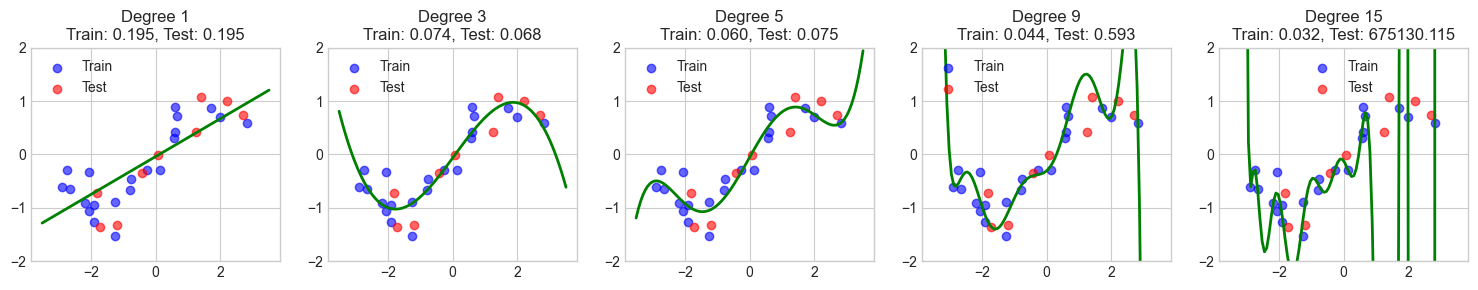

In [17]:
# Fit polynomials of different degrees
degrees = [1, 3, 5, 9, 15]
fig, axes = plt.subplots(1, len(degrees), figsize=(15, 3))

train_errors = []
test_errors = []

X_plot = np.linspace(-3.5, 3.5, 100)

for ax, degree in zip(axes, degrees):
    # Create features
    X_train_poly = polynomial_features(X_train, degree)
    X_test_poly = polynomial_features(X_test, degree)
    X_plot_poly = polynomial_features(X_plot, degree)
    
    # Fit
    model = LinearRegressionNormalEq(fit_intercept=False)
    model.fit(X_train_poly, y_train)
    
    # Predict
    y_train_pred = model.predict(X_train_poly)
    y_test_pred = model.predict(X_test_poly)
    y_plot = model.predict(X_plot_poly)
    
    # Errors
    train_mse = np.mean((y_train - y_train_pred)**2)
    test_mse = np.mean((y_test - y_test_pred)**2)
    train_errors.append(train_mse)
    test_errors.append(test_mse)
    
    # Plot
    ax.scatter(X_train, y_train, c='blue', alpha=0.6, label='Train')
    ax.scatter(X_test, y_test, c='red', alpha=0.6, label='Test')
    ax.plot(X_plot, y_plot, 'g-', linewidth=2)
    ax.set_title(f'Degree {degree}\nTrain: {train_mse:.3f}, Test: {test_mse:.3f}')
    ax.set_ylim(-2, 2)
    ax.legend()

plt.tight_layout()
plt.show()

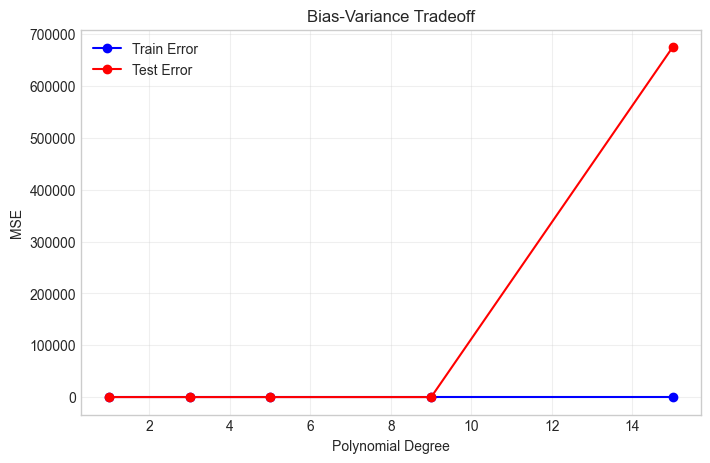


Bias-Variance Tradeoff:
- Low degree: High bias (underfitting), low variance
- High degree: Low bias, high variance (overfitting)
- Optimal complexity minimizes test error


In [18]:
# Plot train vs test error as function of complexity
plt.figure(figsize=(8, 5))
plt.plot(degrees, train_errors, 'bo-', label='Train Error')
plt.plot(degrees, test_errors, 'ro-', label='Test Error')
plt.xlabel('Polynomial Degree')
plt.ylabel('MSE')
plt.title('Bias-Variance Tradeoff')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\nBias-Variance Tradeoff:")
print("- Low degree: High bias (underfitting), low variance")
print("- High degree: Low bias, high variance (overfitting)")
print("- Optimal complexity minimizes test error")

## 6. Exercises

1. [ ] Implement mini-batch SGD for linear regression
2. [ ] Add learning rate scheduling to GD and observe convergence
3. [ ] Implement cross-validation to select optimal polynomial degree

## Key Takeaways

1. **Normal equations** give closed-form solution when $X^\top X$ is invertible
2. **Gradient descent** is iterative but generalizes to other loss functions
3. **Ridge regression** adds $\lambda ||w||^2$ penalty, making $(X^\top X + \lambda I)$ always invertible
4. **Polynomial features** demonstrate bias-variance tradeoff
5. **Always evaluate on held-out data** to detect overfitting